In [ ]:
import os
from collections import defaultdict as dd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt

# read data

In [34]:
mats = {}
totals = {}

with os.scandir("./data/Jul/labeled_sanitized/") as directory:
    for entry in directory:
        if entry.is_file():
            print(f"reading {entry.name}...")
            with open(entry.path) as file:
                for i, line in enumerate(file.readlines()):
                    if i > 15:
                        idx = i % 7
                        if idx == 3:
                            id_l = line[1:line.index(')')]
                        elif idx == 4:
                            id_r = line[1:line.index(')')]
                        elif idx == 5:
                            if line == 'Y\n':
                                label = 0
                            elif line == 'N\n':
                                label = 1
                            elif line == 'M\n':
                                label = 0.5
                            else:
                                raise ValueError(f"invalid label: '{line}'")
                            pair = (int(id_l[1:]), int(id_r[1:]))
                            source = id_l[0]
                            if source not in mats:
                                mats[source] = dd(int)
                                totals[source] = dd(int)
                            mats[source][pair] += label
                            totals[source][pair] += 1

for mat, total in zip(mats.values(), totals.values()):
    for key in mat:
        mat[key] /= total[key]

reading set_1.txt...


# generate graphs

## real data

In [35]:
for source in mats:
    with open(f"./data/graphs/{source}.txt", "w") as file:
        res = []
        for (u,v), weight in mats[source].items():
            res.append(f"{u} {v} {weight}")
        file.write('\n'.join(res))

## semi-synthetic data

In [36]:
wlist = []
for mat in mats.values():
    for val in mat.values():
        wlist.append(val)

In [37]:
# wlist = st.triang.rvs(0.2, size=1000)

In [38]:
counts = dd(int)
for w in wlist:
    counts[w] += 1
counts_x = sorted(counts.keys())
counts_y = np.linspace(0, 1, num=len(counts))

In [39]:
distributions = [
    st.cosine, 
    st.trapezoid, 
    st.triang, 
    st.truncexpon
]

In [40]:
mles = []
for dist in distributions:
    params = dist.fit(wlist)
    mle = dist.nnlf(params, wlist)
    mles.append(mle)

best_fits = sorted( [(dist.name, mle) for dist, mle in zip(distributions, mles)], key=lambda x: x[1] )

In [41]:
print(best_fits)

[('truncexpon', 33.584730819693974), ('triang', 42.657237967449134), ('trapezoid', 81.71071924396168), ('cosine', 106.47070577349956)]


In [42]:
func = st.triang

In [43]:
params = func.fit(wlist)

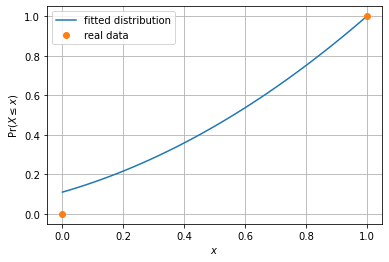

In [44]:
fig, ax = plt.subplots()
# fig.suptitle('CDF for real data and fitted distribution')

domain = np.linspace(0, 1, num=50)
ax.plot(domain, [func.cdf(x, *params) for x in domain], label='fitted distribution')

ax.plot(counts_x, counts_y, 'o', label='real data')

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\Pr(X \leq x)$')

ax.legend()
ax.grid(visible=True)

plt.savefig("plots/distribution_fitting.pdf")

In [45]:
print(f"The best non-pathological fit is the `{func.name}` distribution with parameters {params}.")

The best non-pathological fit is the `triang` distribution with parameters (0.9997601983681824, -0.49722489907722134, 1.497584048711989).


#### random weight function for generating graphs

In [46]:
# def random_weight():
#     # parameters for distribution computed in `labels_to_graph.ipynb`
#     sample = st.triang.rvs(0.9999995032790814, -0.38730256734947843, 1.3873032751477359)
#     return min(1, max(0, sample))